# Julia and Mandelbrot Set Generation Code

This notebook uses an escape time algorithm to approximate images of these fractals. It is also capable of generating animations sweeping through various parameters.

The Mandelbrot Set is defined as all the points $c$ in the complex plane that do not diverge under the iterated mapping $z→z^{2}+c$ where $z_0=c$.

A Julia Set is defined as all the points $c$ in the complex plane that do not diverge under the iterated mapping $z→z^{2}+k$ where $z_0=c$ and $k$ is a complex constant for the entire Julia Set.

Note that there is one Mandelbrot Set, and infinitely many Julia Sets (under these definitions)

<img src='https://drive.google.com/uc?id=1ErQPOV371uEZC8x-n0c09et5tjbpZ9Vr'>
<img src='https://drive.google.com/uc?id=1fqWG7BogyEDBrYbRcSNwyZ31nyHDtOa-' width=50%>





##Imports
*   numpy for handling arrays
*   matplotlib for displaying
*   PIL for saving images
*   output for notifications after long renders

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import output
from PIL import Image

##Utility Functions

saving images, notification sound (high quality renders take a while)

In [ ]:
def save_image(render,name='test'):
  rescaled = (255.0 / render.max() * (render - render.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(name+'.png')

In [ ]:
def play_chord():
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/2/2b/Piano-C-major-chord.ogg").play()')

##Complex Curve Functions
These are used for generating a series of $k$ values for GIFs of Julia Sets. The `(1-1/divs)` term ensures these curves do not overlap themselves when they reach their starting point so the GIFs loop properly.

`complex_circle(n,r,c)` generates $n$ evenly spaced points along a circle with radius $r$ centered at $c$. It is generated using the curve:

$z=re^{i\theta}+c$

$\theta \in [0,2\pi)$

default values are $r=1$ and $c=0$

`complex_cardioid(n,a,b,c)` generates $n$ points on the cardiod formed by the curve

$z=\frac{e^{i\theta}(a-e^{iθ})}{b}+c$

$\theta \in [0,2\pi)$.

The default values of $a=2$, $b=4$, and $c=0$ give the cardiod that forms the boundary of the main continent of the Mandelbrot Set. This is useful because $k$ values near the boundary of the Mandelbrot Set usually generate interesting Julia Sets.

In [ ]:
def complex_circle(npoints, r=1,c=0+0j):
  thetas = np.linspace(0,2*np.pi*(1-1/npoints),npoints)
  return (thetas, r*np.exp(1j*thetas)+c)

In [ ]:
def complex_cardiod(npoints, a=2,b=4,c=0+0j):
  thetas = np.linspace(0,2*np.pi*(1-1/npoints),npoints)
  imthetas = 1j*thetas
  return (thetas, (1/b)*np.exp(imthetas)*(a-np.exp(imthetas))+c)

##Complex Grid Functions
`complex_grid(n,a,b,c,d)` generates a grid of complex numbers with the bounds

$Re(z) \in [a,b]$

$Im(z) \in [c,d]$

with $n$ points along the Real Axis. The number of points along the Imaginary Axis is automatically generated to keep the image proportional. $n$ will be the width of your final image. default values give a square of side length 2 centered at the origin.

`complex_grid_centered(n,cx,cy,dx,dy)` behaves identically to `complex_grid`, but the bounds are centered on the point `(cx,cy)` with half-width `dx` and half-height `dy`. This is useful for generating zooms to specific locations on the Mandelbrot Set (Or Juila Sets).

In [ ]:
def complex_grid(re_steps,real_min=-2, real_max=2, im_min=-2,im_max=2):
  im_steps = int(((im_max-im_min)/(real_max-real_min))*re_steps)
  reals = np.linspace(real_min, real_max, re_steps)
  imags = np.linspace(im_min, im_max, im_steps)
  return [[re + im*1j for re in reals] for im in imags]

In [ ]:
def complex_grid_centered(re_steps,cx=0,cy=0, dx=1, dy=1):
  real_min, real_max = cx-dx,cx+dx
  im_min, im_max = cy-dy,cy+dy
  im_steps = int(((im_max-im_min)/(real_max-real_min))*re_steps)
  reals = np.linspace(real_min, real_max, re_steps)
  imags = np.linspace(im_min, im_max, im_steps)
  return [[re + im*1j for re in reals] for im in imags]

##Julia and Mandelbrot Test Functions

These functions test whether a single point in the complex plane is part of the Julia/Mandelbrot Set. They use an escape time algorithm where if upon iteration $z$ falls outside the radius `r_max`, the number of iterations required to escape is returned. If the point stays within `r_max` after `c_max` iterations, we return either `c_max` or 0 to show that this point is part of the Julia\Mandelbrot Set. It is convential for the Mandelbrot's interior to be dark, and Julia Set interiors to be white (or at least they look the best this way) This can be changed using the `interior` input.

In [ ]:
def mandelbrot_test(z_0,r_max,c_max,interior=0):
  count = 0
  z = z_0
  while np.absolute(z)<r_max:
    if count == c_max:
      count = interior*c_max
      break
    count = count+1
    z = z**2 + z_0
  return count

In [ ]:
def julia_test(z,k,r_max,c_max,interior=1):
  count = 0
  while np.absolute(z)<r_max:
    if count == c_max:
      count = interior*c_max
      break
    count = count+1
    z = z**2 + k
  return count

##Fractal Generation Functions

`mandelbrot_render()` and `julia_render()` return images of Julia/Mandelbrot Sets. They need to be given a complex grid `comps` generated by `complex_grid`. Grids with sizes over 2000 take a while to generate the fractals.

`r_max` and `c_max` are the maximum radius and counts for the escape time algorithm, and are passed to the test function.

`show` (boolean) toggles whether the final image is shown

`save` (boolean) toggles whether the final image is saved to a file

`chord` (boolean) toggels whether a notification sound is played after the render finished

In [ ]:
def mandelbrot_render(comps,r_max=2,c_max=200,show=False, save=False, chord=False,name='0'):
  counts = np.empty_like(comps)
  for n,ax in enumerate(comps):
    for m,z in enumerate(ax):
      counts[n,m] = mandelbrot_test(z,r_max,c_max)
  mandelbrot_render =  np.absolute(counts)
  if show:
    plt.imshow(mandelbrot_render)
  if save:
    save_image(mandelbrot_render,'mandelbrot_'+name)
  if chord:
    play_chord()
  return mandelbrot_render

In [ ]:
def julia_render(k,comps,r_max=2,c_max=300,show=False, save=False, chord=False):
  counts = np.empty_like(comps)
  for n,ax in enumerate(comps):
    for m,z in enumerate(ax):
      counts[n,m] = julia_test(z,k,r_max,c_max, interior=1)
  julia_render = np.absolute(counts)
  if show:
    plt.imshow(julia_render)
  if save:
    save_image(julia_render,'julia'+str(k))
  if chord:
    play_chord()
  return julia_render

##GIF Generation

`julia_circle_gif(n,comps,r,c)` returns a list of `n` generated julia sets with $k$ values evenly spaced around a circle with radius `r` and center at `c` (complex) on the region of given by the complex grid  `comps`.

`chord` (boolean) toggels whether a notification sound is played after the render is finished

`save` (boolean) toggles whether the julia sets are saved to a GIF

In [ ]:
def julia_circle_gif(njulias,comps,r=1,c=0+0j,r_max=2,c_max=300,chord=False,save=False):
  julia_sets = []
  thetas, ks = complex_circle(njulias,r,c)
  for i,k in enumerate(ks):
    counts = np.empty_like(comps)
    for n,ax in enumerate(comps):
      for m,z in enumerate(ax):
        counts[n,m] = julia_test(z,k,r_max,c_max,interior=1)
    julia_sets.append(np.absolute(counts))
    print(str(k)+' done! ('+str(i+1)+'/'+str(njulias)+')')
  if save:
    rescaled_julias = [(255.0 / c_max * (julia)).astype(np.uint8) for julia in julia_sets]
    julia_imgs = [Image.fromarray(img) for img in rescaled_julias]
    julia_imgs[0].save("Julia_sets_r_"+str(r)+"_c_"+str(c)+"_circle_"+str(njulias)+".gif", save_all=True, append_images=julia_imgs[1:], duration=100, loop=0)
  if chord:
    play_chord()
  return julia_sets

##Example Julia Set

In [ ]:
grid_1000 = complex_grid(1000)
k=-1.26+0.03j

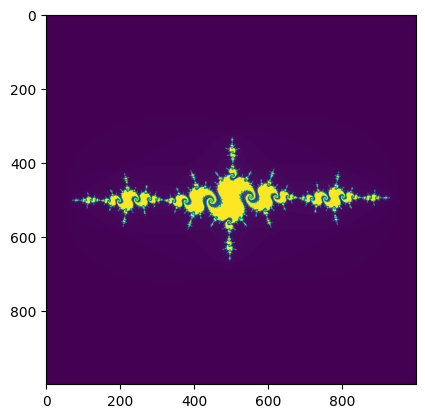

In [ ]:
julia1=julia_render(k,grid_1000,show=True,save=True,chord=True)

##Example Mandelbrot Set

In [ ]:
mgrid_1000=complex_grid(1000,-2,1.25,-1.25,1.25)

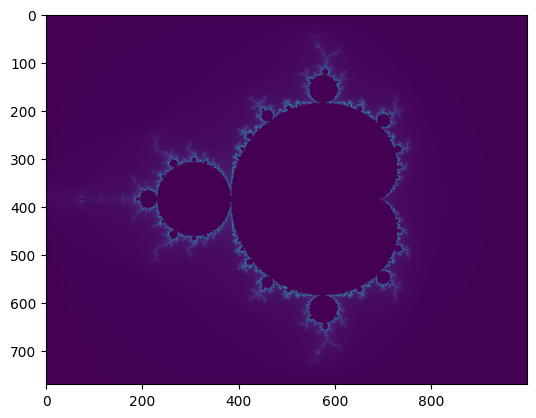

In [ ]:
man1 = mandelbrot_render(mgrid_1000,show=True,save=True,chord=True)

##Example Julia Gif
Keep in mind that Julia Set generation times vary wildly due to the number of interior points (which depends on $k$). Increasing grid size or gif frames may not scale as you expect with time.

In [ ]:
dx=1.8
dy=0.8
compsgif=complex_grid_centered(2000,dx=1.8,dy=0.8)

In [ ]:
julia_gifs1=julia_circle_gif(200,compsgif,r=0.01,c=-1.26+0.05j,chord=True, save=True)

(-1.25+0.05j) done! (1/200)
(-1.2500049343963426+0.05031410759078129j) done! (2/200)
(-1.2500197327157172+0.05062790519529314j) done! (3/200)
(-1.2500443803539691+0.05094108313318515j) done! (4/200)
(-1.2500788529868552+0.05125333233564305j) done! (5/200)
(-1.2501231165940487+0.05156434465040231j) done! (6/200)
(-1.2501771274927131+0.05187381314585725j) done! (7/200)
(-1.2502408323806125+0.05218143241396543j) done! (8/200)
(-1.2503141683887138+0.05248689887164855j) done! (9/200)
(-1.2503970631432306+0.0527899110603923j) done! (10/200)
(-1.2504894348370486+0.053090169943749474j) done! (11/200)
(-1.2505911923104578+0.053387379202452914j) done! (12/200)
(-1.2507022351411174+0.053681245526846784j) done! (13/200)
(-1.2508224537431603+0.053971478906347806j) done! (14/200)
(-1.2509517294753398+0.05425779291565073j) done! (15/200)
(-1.2510899347581164+0.05453990499739547j) done! (16/200)
(-1.2512369331995614+0.05481753674101716j) done! (17/200)
(-1.2513925797299605+0.055090414157503716j) done!